In [41]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Working on new docking oracles.

In [43]:
from dgym.envs.oracle import DockingOracle
from dgym.envs.utility import ClassicUtilityFunction
from dgym.envs.library_designer import Designer, Generator

designer = Designer(reactions, Generator(building_blocks, fingerprints))

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 30.,
    'size_y': 30.,
    'size_z': 30.,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

# create evaluators
docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8.5, 10_000),
    acceptable=(6, 10_000)
)

Create selection loop.

In [44]:
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials, progress=False):
        
        results = []
        for trial in tqdm(range(num_trials)):

            observations, info = drug_env.reset()

            if progress:
                pbar = tqdm(total = drug_env.budget)
            
            while True:
                action = drug_agent.act(observations)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                try:
                    print(observations.annotations['ADAM17 affinity'].dropna())
                except:
                    pass
                
                if progress:
                    pbar.n = len(drug_env.library.annotated)
                    pbar.update()
                
                if terminated or truncated:
                    break

            result = {
                'trial': trial,
                **vars(drug_agent)
            }

            if terminated:
                cost = len(drug_env.library.annotated)
                result.update({'cost': cost, 'outcome': 1})

            if truncated:
                result.update({'outcome': 0})

            results.append(result)

        return results

Run experiment.

In [63]:
from dgym.molecule import Molecule
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent

molecule = Molecule(
    'Cc1cccc(-c2cccc(C(=O)NCc3ccc(F)cc3)c2)c1',
    reactants = ['NCc1ccc(F)cc1', 'Cc1cccc(-c2cccc(C(=O)O)c2)c1']
)

drug_env = DrugEnv(
    designer,
    # library = deck[[300]].update_annotations(),
    library = dg.collection.MoleculeCollection([molecule]).update_annotations(),
    assays = [docking_utility.oracle],
    budget = 100,
    utility_function = docking_utility,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 100}},
    {'name': 'ADAM17 affinity'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = docking_utility,
    epsilon = 0.0,
    branch_factor = 5
)

experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1, progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0     6.321288
1     6.321288
14    6.131192
34    6.414551
70    6.158041
Name: ADAM17 affinity, dtype: float64
0     6.321288
1     6.321288
14    6.131192
34    6.414551
70    6.158041
Name: ADAM17 affinity, dtype: float64


KeyboardInterrupt: 

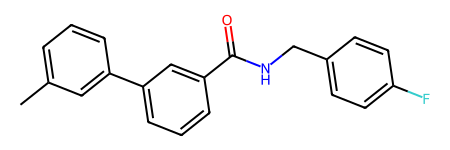

In [65]:
drug_env.library[0]

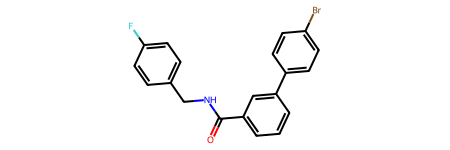

In [64]:
drug_env.library[34]